<a href="https://colab.research.google.com/github/megsum/FewShotMarioLevelUpdates/blob/main/LSTM-Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources and Notes

Useful links:
https://towardsdatascience.com/lstm-recurrent-neural-networks-how-to-teach-a-network-to-remember-the-past-55e54c2ff22e

https://cnvrg.io/pytorch-lstm/

https://github.com/adamsumm/SMB_RNN_TUTORIAL

Notes from Megan:

I am actually a bit more familiar with PyTorch now because of the other course I'm taking and think it might be a good way to work on this assignment. I'm going to keep a tensorflow approach in here, but start working on the PyTorch approach and see how it goes!


TODO for Final Project
* ✅Make sure the output is the same as the level but with question mark added in some places. This is a big unknown for me still. I'm not sure the best way to do this
* ✅Add more to the LSTM. New layer, a better foundation between the long term memory information and forget gate.
* Split between test levels and training levels potentially. Is that needed for this approach?
* ✅ Measure the accuracy difference between the real level and the level outputted with the LSTM
* ✅ Try the LSTM with different block removed (maybe the enemy block)
* Try the LSTM with same block removed, but replace it with a different block. We are currently always replacing the removed block with ground, but it might be useful to try replacing with sky and see if we get a better result
* ✅ Add visualizer 
* ✅ Remove question mark block type from the input
* ✅ Keep question mark in one block type
* ✅ Train on question mark addition level
* ✅ Predict on levels with question marks removed

# Imports and Dataset Preprocessing

Import necessary libraries to the project.


In [ ]:
import numpy as np
import pandas as pd 
import glob
import os
from datetime import datetime
from google.colab import drive
import sys
from PIL import Image

# Torch imports
import torch
import torch.nn as nn
from torch.autograd import Variable


In [ ]:
# Link to drive to get access to the dataset
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data exists in google drive. Mounting it to this location so it can be accessed from Google Colab
# TODO: need to split between training and test data still
# X paths contain all the old levels (This eventually will need to be reversed with the y paths, but I want more samples to go off of right now)
x_train_path = '/content/drive/MyDrive/datasets/SMB_Data/Training_Level/' 

sprites_path = '/content/drive/MyDrive/datasets/SMB_Data/Sprites/'

# y paths contain the updated level with the new block
y_path = '/content/drive/MyDrive/datasets/SMB_Data/Modified_SMB_Data/' 

# Output location to place the updated levels with the new block addtion
output_path = '/content/drive/MyDrive/datasets/SMB_Data/Output/'


In [ ]:
# Block mapping for one-hot vector encoding
tiles = [
        "X",
        "S",
        "-",
        "?",
        "Q",
        "E",
        "<",
        ">",
        "[",
        "]",
        "o",
        "B",
        "b"
        ]
    
print (tiles)

['X', 'S', '-', '?', 'Q', 'E', '<', '>', '[', ']', 'o', 'B', 'b']


Define Parameters


In [ ]:
# hyperparameters
# I used 2000 epochs because the generator started giving good results when the loss was under 0.2 which took around 1500 epochs
num_epochs = 2000
learning_rate = 0.01

input_size = 13 #number of features
hidden_size = 10 #number of features in hidden state
num_layers = 2 #number of stacked lstm layers.

num_classes = 13 #number of output classes 

maxlen =  48 # Max length of a row. Will segment the levels into this size of chunks

step = 1 # Step size 

modified_char = ["b", "B"] # This allows us to compare accuracy of the missing character

In [ ]:
# Following this approach https://github.com/adamsumm/SMB_RNN_TUTORIAL/blob/master/So%20you%20want%20to%20replicate%20my%20work.ipynb
# Load updated level into training level list
# This should give us a level in vertical strips that the LSTM can use as sequential data
def parse_levels(path):
  outstr = ''
  for levelFile in glob.glob(os.path.join(path, "*.txt")):
    print ("Processing: " + levelFile) #print out which level is being loaded
    with open(levelFile) as fp:
      for level in fp:
        level = level.strip('\n')
        width = len(level[0])
        height = len(level)
        for column in range(width):
            for row in range(height):
                outstr += level[row][column]
  return outstr

# Helper functions to convert to and from a tile based representation
def tile_to_one_hot_level(text):
  sentences = []
  next_chars = []
  # Convert data into batches
  for i in range(0, len(text) - maxlen, step):
      sentences.append(text[i: i + maxlen])
      next_chars.append(text[i + maxlen])

  # Create sequential arrays for X and y
  X = np.zeros((len(sentences), maxlen, len(tiles)), dtype=bool)
  y = np.zeros((len(sentences), len(tiles)), dtype=bool)
  for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, tiles.index(char)] = 1
    y[i, tiles.index(next_chars[i])] = 1
  return X, y

# Referenced from https://github.com/Mawiszus/TOAD-GAN/blob/master/mario/level_utils.py
def one_hot_to_tile_level(level):
  """ Converts a full token level tensor to an ascii level. """
  ascii_level = ''
  for i in range(len(level)):
    for j in range(len(level[i])):
      if level[i][j] == 1:
        ascii_level += tiles[j]
      if len(ascii_level) % maxlen == 0:
        ascii_level += "\n"
  return ascii_level


In [ ]:
'''
Data preprocessing steps
1) Read the dataset

2) Convert text files into an array of strings (each string represents a level)

3) Split one level into multiple samples

4) May need to convert the characters into one hot encoding

5) Convert the array of strings into a tensor that can be used in pytorch
'''
training_text = parse_levels(x_train_path)
y_text = parse_levels(y_path)
X, y = tile_to_one_hot_level(training_text)
y_hat, _ = tile_to_one_hot_level(y_text)

# Convert one hot encoding to a tensor for PyTorch
X_tensor = torch.Tensor(X)
y_tensor = torch.Tensor(y)
y_hat_tensor = torch.Tensor(y_hat)

Processing: /content/drive/MyDrive/datasets/SMB_Data/Training_Level/Question-mario-4-2.txt
Processing: /content/drive/MyDrive/datasets/SMB_Data/Modified_SMB_Data/question-mario.txt


# PyTorch LSTM

In [ ]:
'''
Step 1: Get data with specific block removed. (Maybe the question mark block for testing)

Step 2: Try one level with the question mark added to it and train on it.

Step 3: Cross the levels without the question mark with the level with the question mark and insert the new block

Step 4: Compare the new levels with the old level and report accuracy
'''

# Used https://cnvrg.io/pytorch-lstm/ as a starting point
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    
    # Inputs
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size

    # Neural Net layers
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.linear_1 = nn.Linear(hidden_size  * num_layers, 128) 
    self.linear_2 = nn.Linear(128, num_classes) 
    self.relu = nn.ReLU()
    
  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers, len(x), self.hidden_size))
    c_0 = Variable(torch.zeros(self.num_layers, len(x), self.hidden_size)) 

    # LSTM will take x and output the hidden layer
    output, (hn, _) = self.lstm(x, (h_0, c_0))

    hn = hn.view(-1, self.hidden_size * num_layers) #reshaping the data for Dense layer next

    # Dense layers to resize data
    out = self.relu(hn)
    out = self.linear_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.linear_2(out)

    return out

In [ ]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.CrossEntropyLoss()    # Cross Entropy Loss
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 

for epoch in range(num_epochs):
  outputs = lstm.forward(X_tensor) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_tensor)
 
  loss.backward() #calculates the loss of the loss function
  # Generate level based off training

  train_predict = lstm(y_hat_tensor)#forward pass
  data_predict = train_predict.data.numpy() #numpy conversion

  oh_predict = np.zeros(data_predict.shape)
  for i in range(len(data_predict)):
    index = np.argmax(data_predict[i])
    oh_predict[i][index] = 1

  level_predict = one_hot_to_tile_level(oh_predict)

  print (level_predict)
  optimizer.step() #improve from loss, i.e backprop
  print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Streaming output truncated to the last 5000 lines.
----------------------------<]----[]-----------
-----------------------------------------------
-----------------------------------------------
--------------XXXXXXXXXXXXXXXXXX-XX-XXXXXXX--X
Epoch: 1666, loss: 0.19314

-----------------------------------------------
-----------------------------------------------
------SSS--S---SS--S-SSSSSSSSSSSS--------------
-----------------------------------------------
----S-------S--S--S-SSSSSSSSS-----SS-----------
------------------------------------S----------
-----------------------------------------------
-----------------------------------------------
------<]----[]---------------------------------
----------------------------<]----[]-----------
-----------------------------------------------
-----------------------------------------------
--------------XXXXXXXXXXXXXXXXXX-XX-XXXXXXX--X
Epoch: 1667, loss: 0.19307

-----------------------------------------------
-------------------------------

In [ ]:
# Generate level based off training
train_predict = lstm(y_hat_tensor)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion

oh_predict = np.zeros(data_predict.shape)
# Convert max probability to one hot encoding
for i in range(len(data_predict)):
  for j in range(len(data_predict[i])):
    index = np.argmax(data_predict[i])
    oh_predict[i][index] = 1
level_predict = one_hot_to_tile_level(oh_predict)
print (level_predict)


-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
----------SSS----------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
----------------------B--E-----------<-----B---
--->----BBB----BB------bB-[B---]-->--]B-----b--
--b-------XXXXXXXXXXXXXX------XXXXXXXXXXXXXX--


# Visualizer

{0: '-----------------------------------------------', 1: '------SSS--S---SS--S-SSSSSSSSSSS?--------------', 2: '-----------------------------------------------', 3: '-------------------------SSSS-----SQS----------', 4: '------------------------------------S----------', 5: '-----------------------------------------------', 6: '-----------------------------------------------', 7: '------<]----[]---------------------------------', 8: '----------------------------<]?---[]-----------', 9: '-----------------------------------------------', 10: '-----------------------------------------------', 11: '--------------XXXXXXXXXXXXXXXXXX-XX-XXXXXXX--XX'}


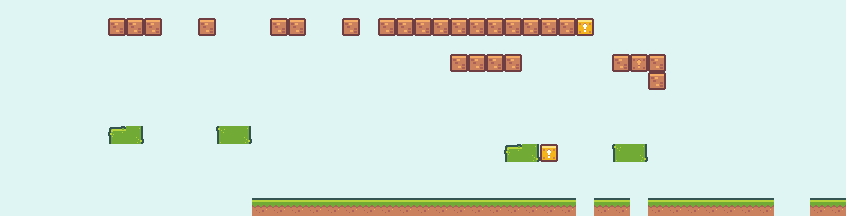

In [ ]:
'''

Script for visualizing the generated output.txt levels
Implemented from warmup assignment

'''
# Manual level predict when we don't want to use the last output
level_predict = '''-----------------------------------------------
-----------------------------------------------
------SSS--S---SS--S-SSSSSSSSSSS?--------------
-----------------------------------------------
-------------------------SSSS-----SQS----------
------------------------------------S----------
-----------------------------------------------
-----------------------------------------------
------<]----[]---------------------------------
----------------------------<]?---[]-----------
-----------------------------------------------
-----------------------------------------------
--------------XXXXXXXXXXXXXXXXXX-XX-XXXXXXX--XX'''

#Load the set of all spritesv
sprites = {}
for filename in glob.glob(os.path.join(sprites_path, "*.png")):
  im = Image.open(filename)
  splits = filename.split("/")
  name = splits[-1][:-4]
  sprites[name] = im.convert('RGBA')

#This gives the mapping between the tile values and the associated sprite
visualization = {}
visualization["S"] = "brick"
visualization["s"] = "brick"
visualization["?"] = "exclamationBox"
visualization["Q"] = "exclamationBoxEmpty"
visualization["E"] = "enemy"
visualization["<"] = "bushTopLeft"
visualization[">"] = "bushTopRight"
visualization["["] = "bushLeft"
visualization["]"] = "bushRight"
visualization["o"] = "coin"
visualization["B"] = "cannonTop"
visualization["b"] = "cannonBottom"

# This reads in the level
level = {}
y = 0

splits = level_predict.split("\n")
for line in splits[1::]:
	if len(line) < 48 - 1:
		continue
	level[y] = line
	y+=1
print(level)
#Multiply by 18 here as each of the sprites is 18*18
image = Image.new("RGB", (18*len(level[0]), 18*len(level.keys())), color=(223, 245, 244)) #This creates an initially blank image for the level
pixels = image.load() #This loads the level image's pixels so we can edit them

maxY = len(level.keys())
maxX = len(level[0])
for y in range(0, maxY):
	for x in range(0, maxX):
		imageToUse = None
		if level[y][x] in visualization.keys():
			imageToUse = sprites[visualization[level[y][x]]]
		elif level[y][x]=="X":
			imageToUse = sprites["groundTop"]
		if not imageToUse == None:
			#If we have a sprite (imageToUse) copy its pixels over
			pixelsToUse = imageToUse.load()
			for x2 in range(0, 18):
				for y2 in range(0, 18):
					if pixelsToUse[x2,y2][3]>0:
						pixels[x*18+x2,y*18+y2] = pixelsToUse[x2,y2][0:-1]

# Display the image
image

In [ ]:
# Create a timestamp as a unique identifier for our output
# current date and time
now = datetime.now()
t = now.strftime("%m-%d_%H:%M")

# Write the output to google drive location
with open(output_path + '/output-%s.txt' % t, 'w') as writefile:
    writefile.write(level_predict)

# Save an image visualization to output too
image.save(output_path + "output-%s.png" % t)

# Report Accuracy

The accuracy will be calculated based on how many of the newly added blocks are in the correct location. We will try this on a bunch of levels. The accuracy will most likely be very low, but it should be something we can compare to our other approach.

Will need to also measure accuracy based on the number of added blocks that are correct. This will stop a level that produces too many of the added block by having inflated accuracy.

In [ ]:
def compare_strings(str1, str2):
  correct_char_count = 0
  total_modified_char_count = 0
  for i in range(len(str1)-1):
    if str1[i] == modified_char:
      if str2[i+1] == str1[i]:
        correct_char_count += 1
        # total_modified_char_count += 1 # commented this line but might be wrong
      total_modified_char_count += 1
    elif str2[i] == modified_char:
    # elif str2[i+1] == modified_char: 
      total_modified_char_count += 1

  if total_modified_char_count:
    return correct_char_count/total_modified_char_count
  else:
    return 0

# TODO: Don't do this manually :/
original_question = '''-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-------------E---------------------------------
-----------SSSSSSSS---SSS?--------------?------
-----------------------------------------------
----------E------------------------------------
-----------------------------------------------
--------S?S--------------S-----SS----?--?--?---
-----------------------------------------------
-----------------------------------------------
--------------------------E-E--------E---------
XXXXXXXXXXXXXXXXX---XXXXXXXXXXXXXXXXXXXXXXXXXXX'''

original_coin = '''-----------------------------------------------
-----------------------------------------------
oo---------------------------------------------
---------------------------Q-------------------
---------------ooooooo----------XXX------------
XXX---------XX-----------------------------XXoo
-------------------------XX--------------------
------------------XX---------------------------
-----------------------------------------------
---XXXXX-----------------------------XXXXXX----
-----------------------------------------------
---------------------XXXXX---------------------
-----------------------------------------------
---------XXXX--XXXX----------------------------'''

original_cannon = '''-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
--------?SS------------------------------------
-----------------------------------------------
---------------------------------------------B-
---------------------------------------------b-
--------------------QQQQ-------------------SSXS
-----E---------------------B-----E---B---------
B--------b-------B--E------b---------b---------
b--------B-------b-------------------B---------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'''

accuracy = compare_strings(level_predict, original_coin)

print("Accuracy of level is %s" % accuracy)

Accuracy of level is 0.0


In [ ]:
modified_char = 'Q'
test_str = '''-----------------------------------------------
-----------------------------------------------
-------------E---------------------------------
-----------SSSSSSSS?--SSSQ---------------------
---------------------?-------------------------
----------E------------------------------------
-----------------------------------------------
--------S-S--------------S-----SS----Q--Q--Q---
-----------------------------------------------
-----------------------------------------------
--------------------------E-E--------E---------
XXXXXXXXXXXXXXXXX---XXXXXXXXXXXXXXXXXXXXXXXXXXX'''

accuracy = compare_strings(test_str, original_question)

print("Accuracy of level is %s" % accuracy)

Accuracy of level is 0.0


In [ ]:
test_line = test_str.splitlines()
test_line = np.array([[*l] for l in test_line])
print(test_line[7:12,35:40])

[['-' '-' 'Q' '-' '-']
 ['-' '-' '-' '-' '-']
 ['-' '-' '-' '-' '-']
 ['-' '-' 'E' '-' '-']
 ['X' 'X' 'X' 'X' 'X']]


In [ ]:
qmark_path = '/content/drive/MyDrive/datasets/SMB_Data/Output/question block'
cannon_path = '/content/drive/MyDrive/datasets/SMB_Data/Output/cannon sign block'
coin_path = '/content/drive/MyDrive/datasets/SMB_Data/Output/coin block'

def evaluate_results(modified_chars, original_str, path):
  correct_char_count = 0
  total_modified_char_count = 0
  output_files = glob.glob(path+'/*.txt')

  for path in output_files:
    # print(path)
    f = open(path)
    output_str = f.read()
    # print("original is")
    # print(original_str)
    # print("\nPredicted is")
    # print(output_str)
    for i in range(min(len(original_str), len(output_str))-1):
      if original_str[i] in modified_chars:
        # print(i, output_str[i+1])
        if output_str[i+1] in modified_chars:
          correct_char_count += 1
        total_modified_char_count += 1
      # elif output_str[i+1] in modified_char: 
      #   total_modified_char_count += 1
    # print(compare_strings(original_str, output_str))

  if total_modified_char_count:
    return correct_char_count/total_modified_char_count
  else:
    return 0

print("Accuracy of coin levels is: ", evaluate_results(['o'], original_coin, coin_path))
print("Accuracy of ? levels is: ", evaluate_results(['Q', '?'], original_question, qmark_path))
print("Accuracy of cannon levels is: ", evaluate_results(['b', 'B'], original_cannon, cannon_path))


Accuracy of coin levels is:  0.09090909090909091
Accuracy of ? levels is:  0.023809523809523808
Accuracy of cannon levels is:  0.038461538461538464


The window-based version

In [ ]:
qmark_path = '/content/drive/MyDrive/datasets/SMB_Data/Output/question block'
cannon_path = '/content/drive/MyDrive/datasets/SMB_Data/Output/cannon sign block'
coin_path = '/content/drive/MyDrive/datasets/SMB_Data/Output/coin block'

def evaluate_results(margins, modified_chars, original_str, path):
  correct_char_count = 0
  total_modified_char_count = 0
  output_files = glob.glob(path+'/*.txt')
  # print("\noriginal is")
  # print(original_str)
  original_str = original_str.splitlines()
  original_str = np.array([[*l] for l in original_str], dtype=object)
  orig_shape = (len(original_str), len(original_str[0]))

  for path in output_files:
    # print(path)
    f = open(path)
    output_str = f.read()
    # print("\nPredicted is")
    # print(output_str)
    output_str = output_str.splitlines()
    for i in range(len(output_str)):
      if len(output_str[i]) > 47:
        output_str[i] = output_str[i][:47]
      elif len(output_str[i]) < 47:
        while len(output_str[i]) <47:
          output_str[i] = output_str[i]+'-'

    output_str = np.array([[*l] for l in output_str], dtype=object)
    out_shape = (len(output_str), len(output_str[0]))
    # print(output_str)
    # print(out_shape)
    m, n = margins

    for i, line in enumerate(original_str):
      for j, char in enumerate(line):
        if char in modified_chars:
          # print("i, j =", i, j)
          # print("window dims ", max(0, i-m), min(out_shape[0], i+m+1),max(0, j-n), min(out_shape[1], j+n+1))
          # print(output_str.shape)
          window = output_str[max(0, i-m): min(out_shape[0], i+m+1), max(0, j-n): min(out_shape[1], j+n+1)]
          # print(window)
          if any(any(e in l for e in modified_chars) for l in window):
            correct_char_count += 1
          total_modified_char_count +=1

  # print(correct_char_count, total_modified_char_count)
  if total_modified_char_count:
    return correct_char_count/total_modified_char_count
  else:
    return 0

for m, n in [(1,1), (2,2), (2,3), (3,3), (5,5), (10,10)]:  
# for m,n in [(2,2)]:
  print("===========Accuracy results using a {}x{} window===========".format(2*m+1, 2*n+1)) 
  print("Accuracy of coin levels is: ", evaluate_results((m, n),['o'], original_coin, coin_path))
  print("Accuracy of ? levels is: ", evaluate_results((m, n),['Q', '?'], original_question, qmark_path))
  print("Accuracy of cannon levels is: ", evaluate_results((m, n),['b', 'B'], original_cannon, cannon_path))
  print("=========================================================\n")


===========Accuracy results using a 3x3 window===========
Accuracy of coin levels is:  0.2727272727272727
Accuracy of ? levels is:  0.2619047619047619
Accuracy of cannon levels is:  0.24615384615384617

===========Accuracy results using a 5x5 window===========
Accuracy of coin levels is:  0.3939393939393939
Accuracy of ? levels is:  0.30952380952380953
Accuracy of cannon levels is:  0.3153846153846154

===========Accuracy results using a 5x7 window===========
Accuracy of coin levels is:  0.47474747474747475
Accuracy of ? levels is:  0.3333333333333333
Accuracy of cannon levels is:  0.4307692307692308

===========Accuracy results using a 7x7 window===========
Accuracy of coin levels is:  0.47474747474747475
Accuracy of ? levels is:  0.42857142857142855
Accuracy of cannon levels is:  0.47692307692307695

===========Accuracy results using a 11x11 window===========
Accuracy of coin levels is:  0.5555555555555556
Accuracy of ? levels is:  0.7619047619047619
Accuracy of cannon levels is:  0.

Another version of accuracy with a margin(m) for correct prediction. Instead considering only the character with index i, we consider the interval including m chars before and after.

In [ ]:
def compare_strings_wmargin(str1, str2, margin=0):
  correct_char_count = 0
  total_modified_char_count = 0

  for i in range(len(str1)):
    if str1[i] == modified_char:
      if modified_char in str2[max(0, (i+1)-margin): min(len(str2), (i+1)+margin+1)]:
        correct_char_count += 1
        # total_modified_char_count += 1 # commented this line but might be wrong
      total_modified_char_count += 1
    elif str2[i+1] == modified_char:
      if modified_char not in str1[max(0, i-margin): min(len(str2), i+margin+1)]:
        total_modified_char_count += 1
      
  if total_modified_char_count:
    return correct_char_count/total_modified_char_count
  else:
    return 0

# TODO: Don't do this manually :/
original_question = '''-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-----------------------------------------------
-------------E---------------------------------
-----------SSSSSSSS---SSS?--------------?------
-----------------------------------------------
----------E------------------------------------
-----------------------------------------------
--------S?S--------------S-----SS----?--?--?---
-----------------------------------------------
-----------------------------------------------
--------------------------E-E--------E---------
XXXXXXXXXXXXXXXXX---XXXXXXXXXXXXXXXXXXXXXXXXXXX'''

original_coin = '''-----------------------------------------------
-----------------------------------------------
oo---------------------------------------------
---------------------------Q-------------------
---------------ooooooo----------XXX------------
XXX---------XX-----------------------------XXoo
-------------------------XX--------------------
------------------XX---------------------------
-----------------------------------------------
---XXXXX-----------------------------XXXXXX----
-----------------------------------------------
---------------------XXXXX---------------------
-----------------------------------------------
---------XXXX--XXXX----------------------------'''

for margin in range(5):
  accuracy = compare_strings_wmargin(level_predict, original_coin, margin)

  print("Accuracy of level is with margin {}, is: {}".format(margin, accuracy))

Accuracy of level is with margin 0, is: 0
Accuracy of level is with margin 1, is: 0
Accuracy of level is with margin 2, is: 0
Accuracy of level is with margin 3, is: 0
Accuracy of level is with margin 4, is: 0


Accuracy with a window